# Imports

In [45]:
from getdist import loadMCSamples
from getdist import plots
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

# Triplots

In [46]:
lcdm_samples = loadMCSamples('/home/vitor-petri/projects/cobaya/coding/vitor-cobaya-lcdm/chains/lcdm')
fld_samples = loadMCSamples('/home/vitor-petri/projects/cobaya/coding/vitor-cobaya-fld/chains/fld')
int_samples = loadMCSamples('/home/vitor-petri/projects/cobaya/coding/vitor-cobaya-int/chains/int')

p_lcdm = lcdm_samples.getParams()
p_fld = fld_samples.getParams()
p_int = int_samples.getParams()

fld_samples.addDerived(p_fld.w0_fld,'w_0',r'w_0')
fld_samples.addDerived(p_fld.wa_fld,'w_a',r'w_a')

int_samples.addDerived(p_int.w0_int,'w_0',r'w_0')
int_samples.addDerived(p_int.wa_int,'w_a',r'w_a')

lcdm_samples.addDerived(p_lcdm.Omega_m,'Omega_m2',r'\Omega_m')
fld_samples.addDerived(p_fld.Omega_m,'Omega_m2',r'\Omega_m')

h0 = p_int.H0 / 100
omega_b = p_int.omega_b / (h0**2)
omega_c = p_int.omega_cdm / (h0**2)
omega_x = 1 - omega_c - omega_b - 0.00138499
omega_c_tilde = omega_c + omega_x*(1 + p_int.w0_int)
Omega_m2 = omega_c_tilde + omega_b + 0.00138499

print(p_int.Omega_m)
print(Omega_m2)

int_samples.addDerived(Omega_m2,'Omega_m2',r'\Omega_m')

[0.33988515 0.33782641 0.34953283 ... 0.50346467 0.54141313 0.52844267]
[0.33978124 0.33772636 0.34940482 ... 0.50342789 0.54137174 0.52839268]


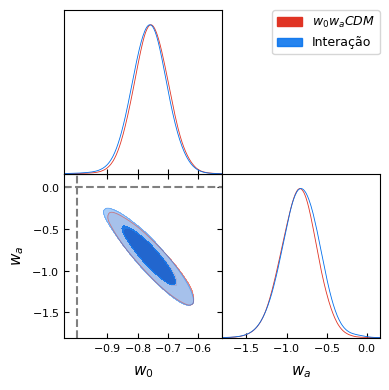

In [47]:
g = plots.getSubplotPlotter()
g.triangle_plot([fld_samples,int_samples], ['w_0','w_a'], 
                filled=True, legend_labels=[r'$w_0w_aCDM$','Interação'])

for i in range(len(g.subplots)):
    for j in range(len(g.subplots[i])):
        ax = g.subplots[i, j]
        if ax is not None and i > j:
            if j == 0:
                ax.axvline(x=-1, color='grey', linestyle='--')
            if i == 1:
                ax.axhline(y=0, color='grey', linestyle='--')

g.export('w0wa.pdf')

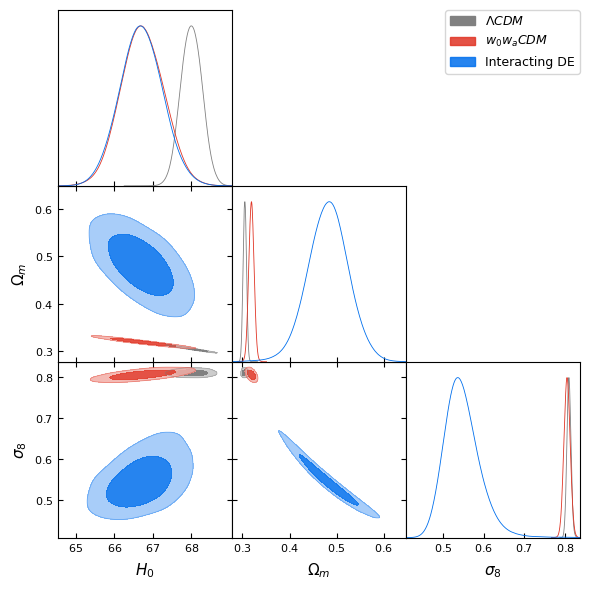

In [48]:
g = plots.getSubplotPlotter()
g.triangle_plot([lcdm_samples,fld_samples,int_samples], ['H0','Omega_m2','sigma8'], 
                filled=True, legend_labels=[r'$\Lambda CDM$',r'$w_0w_aCDM$','Interacting DE'])
g.export('triplot.pdf')

# Plots

## Constants

In [49]:
legend_labels=[r'$\Lambda CDM$',r'$w_0w_aCDM$','Interacting DE']

def get_betstfit_param(model, param):
    with open('/home/vitor-petri/projects/cobaya/coding/bestfit.txt', 'r') as f:
        lines = f.readlines()
    if model == 'lcdm':
        lines = lines[:52]
    elif model == 'fld':
        lines = lines[53:106]
    elif model == 'int':
        lines = lines[107:]
    else:
        raise Exception('Invalid model, choose lcdm, fld or int')
    for line in lines:
        if param in line:
            param_value = line.split()[1]
    return float(param_value)

h0 = get_betstfit_param('lcdm','H0*') / 100
omega_b0 = get_betstfit_param('lcdm','omega_b') / (h0**2)
omega_c0 = get_betstfit_param('lcdm','omega_cdm') / (h0**2)
omega_m0 = get_betstfit_param('lcdm','Omega_m*')
omega_x0 = get_betstfit_param('lcdm','Omega_Lambda*')

h0_fld = get_betstfit_param('fld','H0*') / 100
omega_b0_fld = get_betstfit_param('fld','omega_b') / (h0_fld**2)
omega_c0_fld = get_betstfit_param('fld','omega_cdm') / (h0_fld**2)
omega_m0_fld = get_betstfit_param('fld','Omega_m*')
omega_x0_fld = 1 - omega_m0_fld
r0_fld = omega_c0_fld / omega_x0_fld
w0_fld_bestfit = get_betstfit_param('fld','w0_fld')
wa_fld_bestfit = get_betstfit_param('fld','wa_fld')

h0_int = get_betstfit_param('int','H0*') / 100
omega_b0_int = get_betstfit_param('int','omega_b') / (h0_int**2)
omega_c0_int = get_betstfit_param('int','omega_cdm') / (h0_int**2)
omega_m0_int = omega_b0_int + omega_c0_int
omega_x0_int = 1 - omega_c0_int - omega_b0_int - 0.00138499
w0_int_bestfit = get_betstfit_param('int','w0_int')
wa_int_bestfit = get_betstfit_param('int','wa_int')
omega_c0_int_tilde = omega_c0_int + omega_x0_int*(1 + w0_int_bestfit)
omega_x0_int_tilde = - omega_x0_int * w0_int_bestfit

omega_m0_int_tilde = omega_c0_int_tilde + omega_b0_int + 0.00138499

r0_int = omega_c0_int / omega_x0_int


## Functions

In [50]:
def a(z):
    return 1/(z+1)

def e_square(z):
    return (omega_b0+omega_c0)/a(z)**3+omega_x0

def omega_c(z):
    return (omega_c0/a(z)**3)/e_square(z)

def omega_b(z):
    return (omega_b0/a(z)**3)/e_square(z)

def omega_x(z):
    return omega_x0/e_square(z)

def r(z):
    return omega_c(z)/omega_x(z)

def r_fld(z,w0,wa):
    return r0_fld*np.exp(3*wa*(1-a(z)))*a(z)**(3*(w0+wa))

def e_square_fld(z,w0,wa):
    return (omega_m0_fld) / a(z)**3 + omega_x0_fld * np.exp(3 * wa * (a(z) - 1)) / a(z)**(3 * (1 + w0 + wa))

def omega_c_fld(z,w0,wa):
    return (omega_c0_fld/a(z)**3)/e_square_fld(z,w0,wa)

def omega_b_fld(z,w0,wa):
    return (omega_b0_fld/a(z)**3)/e_square_fld(z,w0,wa)

def omega_m_fld(z,w0,wa):
    return omega_c_fld(z,w0,wa) + omega_b_fld(z,w0,wa)

def r_int(z,w0,wa):
    return -(1+w0+wa*(1-a(z))+r_fld(z,w0,wa)*r0_int/r0_fld)/(w0+wa*(1-a(z)))

def ratio(z,w0fld,wafld,w0int,waint):
    return r_fld(z,w0fld,wafld)/r_int(z,w0int,waint)

def f_int(z,w0,wa):
    return ((3*w0*(1+w0)+wa*(3+6*w0-2*a(z)*(1+3*w0))+3*(wa**2)*(1-a(z))**2)*(r0_int*a(z)**(3*(w0+wa))+np.exp(-3*wa*(1-a(z)))))\
    /(3*(w0+wa*(1-a(z)))*(r0_int*a(z)**(3*(w0+wa))+(1+w0+wa*(1-a(z)))*np.exp(-3*wa*(1-a(z)))))

def e_square_int(z, w0, wa):
    return omega_m0_int / a(z)**3 + omega_x0_int / (np.exp(3 * wa * (1 - a(z))) * a(z)**(3 * (1 + w0 + wa)))

def omega_c_int(z,w0,wa):
    return ((omega_c0_int+omega_x0_int*(1+w0+wa*(1-(1/(z+1))))*np.exp(-3*wa*(1-(1/(z+1))))*(1/(z+1))**(-3*(w0+wa)))*(1/(z+1))**(-3))/e_square_int(z,w0,wa) 

def omega_x_int(z,w0,wa):
    return (-omega_x0_int*(w0+wa*(1-(1/(z+1))))*np.exp(-3*wa*(1-(1/(z+1))))*(1/(z+1))**(-3*(1+w0+wa)))/e_square_int(z,w0,wa)

def q_int(z,w0,wa):
    return f_int(z,w0,wa)*3*(h0_int*100)*np.sqrt(e_square_int(z,w0,wa))*((omega_c_int(z,w0,wa)*omega_x_int(z,w0,wa))/(omega_c_int(z,w0,wa)+omega_x_int(z,w0,wa)))

def omega_b_int(z,w0,wa):
    return (omega_b0_int/((1/(z+1))**3))/e_square_int(z,w0,wa)

def omega_m_int(z, w0, wa):
    return omega_b_int(z,w0,wa) + omega_c_int(z,w0,wa)

def fB_int(z,w0,wa):
    return omega_b_int(z,w0,wa)/omega_m_int(z, w0, wa)

def fB_fld(z,w0,wa):
    return omega_b_fld(z,w0,wa)/omega_m_fld(z,w0,wa)

## Lists

In [51]:
z=np.linspace(0,5,50)

w0_int = [] # 7
wa_int = [] # 8
w0_fld=[]
wa_fld=[]

for i in range(1,5):
    path_int = f'/home/vitor-petri/projects/cobaya/coding/vitor-cobaya-int/chains/int.{i}.txt'
    with open(path_int,'r') as int_data:
        lines = int_data.readlines()
        for line in lines[1:]:
            line = line.split()
            w0_int.append(float(line[7]))
            wa_int.append(float(line[8]))

for i in range(1,5):
    path_fld = f'/home/vitor-petri/projects/cobaya/coding/vitor-cobaya-fld/chains/fld.{i}.txt'
    with open(path_fld,'r') as fld_data:
        lines = fld_data.readlines()
        for line in lines[1:]:
            line = line.split()
            w0_fld.append(float(line[7]))
            wa_fld.append(float(line[8]))

## $\bar{r}(z)$, $\tilde{r}(z)$ e $\frac{\bar{r}(z)}{\tilde{r}(z)}$

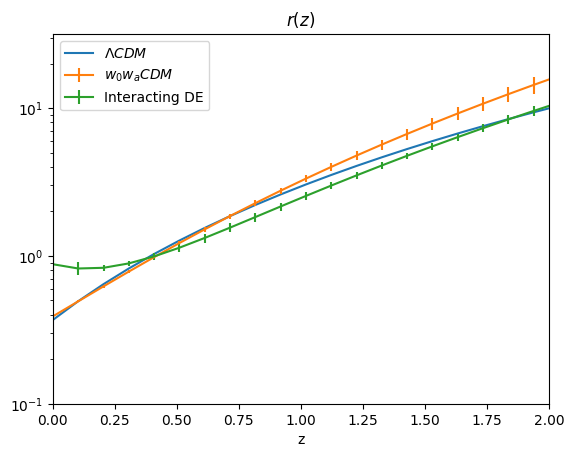

In [66]:
r_int_values=[]
r_fld_values=[]
ratio_values=[]

for i in range(len(w0_int)):
    r_int_values.append(r_int(z,w0_int[i],wa_int[i]))

for i in range(len(w0_fld)):
    r_fld_values.append(r_fld(z,w0_fld[i],wa_fld[i]))
    
for i in range(len(w0_int)):
    ratio_values.append(ratio(z,w0_fld[i],wa_fld[i],w0_int[i],wa_int[i]))

r_fld_std=np.std(r_fld_values,axis=0)
r_int_std=np.std(r_int_values,axis=0)
ratio_std=np.std(ratio_values,axis=0)

plt.plot(z,r(z),label=legend_labels[0])
plt.errorbar(z,r_fld(z,w0_fld_bestfit,wa_fld_bestfit),yerr=r_fld_std,label=legend_labels[1])
plt.errorbar(z,r_int(z,w0_int_bestfit,wa_int_bestfit),yerr=r_int_std,label=legend_labels[2])
plt.xlabel('z')
plt.title(r'$r(z)$')
plt.yscale("log")
plt.ylim(10e-2,10**1.5)
plt.xlim(0,2)
plt.legend()
plt.savefig('r.pdf')
plt.show()

# plt.figure(2)
# plt.errorbar(z,ratio(z,w0_fld_bestfit,wa_fld_bestfit,w0_int_bestfit,wa_int_bestfit),yerr=ratio_std,label='INT')
# plt.plot(z,r(z)/r(z),label=r'$\Lambda CDM$')
# plt.xlabel('z')
# plt.title(r'$\bar{r}(z)/\tilde{r}(z)$')
# plt.yscale("log")
# plt.xlim(0,2)
# plt.legend()
# plt.savefig('ratio.pdf')
# plt.show()


## $\tilde{f}(z)$

In [53]:
f_int_values=[]

for i in range(len(w0_int)):
    f_int_values.append(f_int(z, w0_int[i], wa_int[i]))

f_int_std=np.std(f_int_values,axis=0)

# plt.errorbar(z,f_int(z,w0_int_bestfit,wa_int_bestfit),yerr=f_int_std,label='INT')
# plt.plot(z,f_int(z,-1,0),label='LCDM')
# plt.xlabel('z')
# plt.title(r'$\tilde{f}(z)$')
# plt.xlim(0,2)
# plt.legend()
# plt.savefig('tilde_f.pdf')

## $\tilde{Q}(z)$

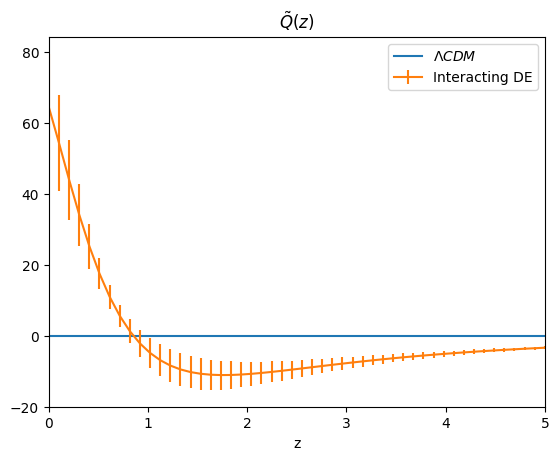

In [54]:
q_int_values=[]

for i in range(len(w0_int)):
    q_int_values.append(q_int(z, w0_int[i], wa_int[i]))

q_int_std=np.std(q_int_values,axis=0)

plt.plot(z,q_int(z,-1,0),label=legend_labels[0])
plt.errorbar(z,q_int(z,w0_int_bestfit,wa_int_bestfit),yerr=q_int_std,label=legend_labels[2])
plt.xlabel('z')
plt.title(r'$\tilde{Q}(z)$')
plt.xlim(0,5)
plt.legend()
plt.savefig('tilde_q.pdf')

## $\Omega_m(z)$

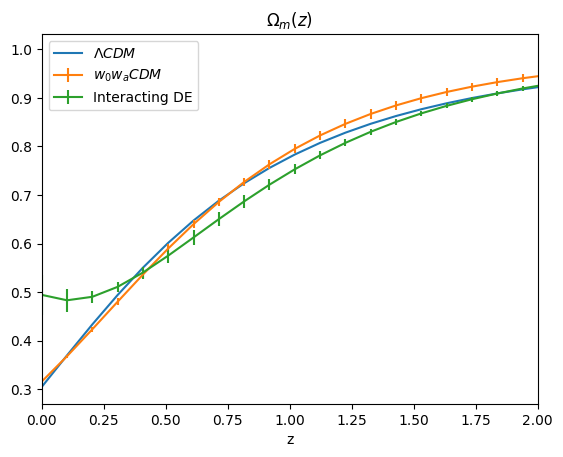

In [55]:
omega_m_int_values=[]
omega_m_fld_values=[]

for i in range(len(w0_int)):
    omega_m_int_values.append(omega_m_int(z, w0_int[i], wa_int[i]))

for i in range(len(w0_fld)):
    omega_m_fld_values.append(omega_b_fld(z, w0_fld[i], wa_fld[i])+omega_c_fld(z, w0_fld[i], wa_fld[i]))

omega_m_int_std=np.std(omega_m_int_values,axis=0)
omega_m_fld_std=np.std(omega_m_fld_values,axis=0)

legend_lcdm = r'$\Lambda CDM$'

plt.plot(z,omega_b(z)+omega_c(z),label=legend_labels[0])
plt.errorbar(z,omega_b_fld(z,w0_fld_bestfit,wa_fld_bestfit)+omega_c_fld(z,w0_fld_bestfit,wa_fld_bestfit),yerr=omega_m_fld_std,label=legend_labels[1])
plt.errorbar(z,omega_m_int(z,w0_int_bestfit,wa_int_bestfit),yerr=omega_m_int_std,label=legend_labels[2])
plt.xlabel('z')
plt.title(r'$\Omega_m(z)$')
plt.xlim(0,2)
plt.legend()
plt.savefig('Om.pdf')

## $f_B(z)$

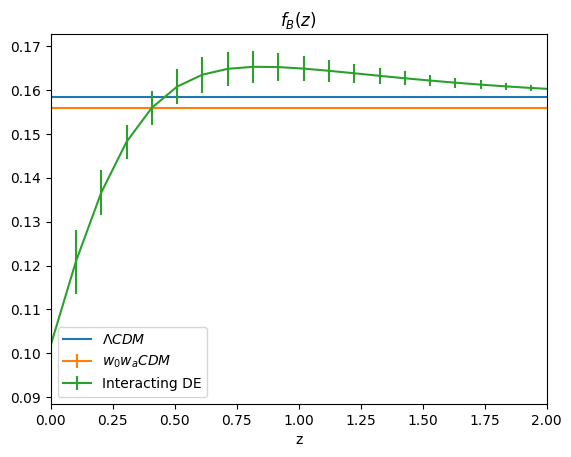

In [56]:
fB_values_int=[]
fB_values_fld=[]

for i in range(len(w0_int)):
    fB_values_int.append(fB_int(z, w0_int[i], wa_int[i]))

for i in range(len(w0_fld)):
    fB_values_fld.append(fB_fld(z, w0_fld[i], wa_fld[i]))

fB_int_std=np.std(fB_values_int,axis=0)
fB_fld_std=np.std(fB_values_fld,axis=0)

plt.plot(z,omega_b(z)/(omega_b(z)+omega_c(z)),label=legend_labels[0])
plt.errorbar(z,fB_fld(z,w0_fld_bestfit,wa_fld_bestfit),yerr=fB_fld_std,label=legend_labels[1])
plt.errorbar(z,fB_int(z,w0_int_bestfit,wa_int_bestfit),yerr=fB_int_std,label=legend_labels[2])
plt.xlabel('z')
plt.title(r'$f_B(z)$')
plt.xlim(0,2)
plt.legend()
plt.savefig('fB.pdf')

# Growth function

## Cosmologies

In [57]:
LCDM = Class()
LCDM.set({'m_ncdm':0.06,'Omega_cdm':0.25,'Omega_b':0.05,'z_max_pk':2,'output':'tCl,lCl,mPk,mTk','k_output_values':0.05,'gauge':'newtonian','non linear':'hmcode','nonlinear_min_k_max':20,'N_ncdm': 1, 'N_ur': 2.0328})
LCDM.compute()
bgLCDM=LCDM.get_background()
ptLCDM=LCDM.get_perturbations()['scalar']
transferLCDM=LCDM.get_transfer()

omega_b_lcdm=bgLCDM['(.)rho_b']/bgLCDM['(.)rho_crit']
omega_c_lcdm=bgLCDM['(.)rho_cdm']/bgLCDM['(.)rho_crit']

FLD = Class()
FLD.set({'m_ncdm':0.06,'Omega_cdm':0.25,'Omega_b':0.05,'Omega_Lambda':0,'w0_fld':w0_fld_bestfit,'wa_fld':wa_fld_bestfit,'z_max_pk':2,'output':'tCl,lCl,mPk,mTk','k_output_values':0.05,'non linear':'hmcode','nonlinear_min_k_max':20,'N_ncdm': 1, 'N_ur': 2.0328})
FLD.compute()
bgFLD=FLD.get_background()
ptFLD=FLD.get_perturbations()['scalar']
transferFLD=FLD.get_transfer()

omega_b_fld=bgFLD['(.)rho_b']/bgFLD['(.)rho_crit']
omega_c_fld=bgFLD['(.)rho_cdm']/bgFLD['(.)rho_crit']

INT = Class()
INT.set({'m_ncdm':0.06,'Omega_cdm':0.25,'Omega_b':0.05,'w0_int':w0_int_bestfit,'wa_int':wa_int_bestfit,'z_max_pk':2,'output':'tCl,lCl,mPk,mTk','k_output_values':0.05,'gauge':'newtonian','non linear':'hmcode','nonlinear_min_k_max':20,'N_ncdm': 1, 'N_ur': 2.0328})
INT.compute()
bgINT=INT.get_background()
ptINT=INT.get_perturbations()['scalar']
transferINT=INT.get_transfer()

omega_b_int=bgINT['(.)rho_b']/bgINT['(.)rho_crit']
omega_c_int=bgINT['(.)rho_cdm']/bgINT['(.)rho_crit']

## $\delta_t$

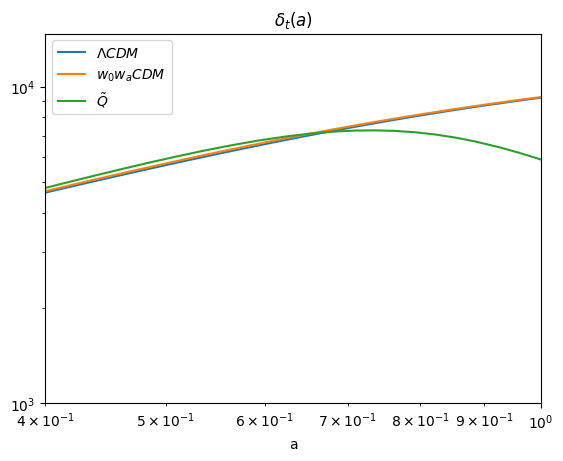

In [58]:
interp_omega_b_lcdm = interp1d(bgLCDM['z'], omega_b_lcdm, kind='linear', fill_value='extrapolate')
interp_omega_c_lcdm = interp1d(bgLCDM['z'], omega_c_lcdm, kind='linear', fill_value='extrapolate')

interp_omega_b_fld = interp1d(bgFLD['z'], omega_b_fld, kind='linear', fill_value='extrapolate')
interp_omega_c_fld = interp1d(bgFLD['z'], omega_c_fld, kind='linear', fill_value='extrapolate')

interp_omega_b_int = interp1d(bgINT['z'], omega_b_int, kind='linear', fill_value='extrapolate')
interp_omega_c_int = interp1d(bgINT['z'], omega_c_int, kind='linear', fill_value='extrapolate')

omega_b_lcdm_interp = interp_omega_b_lcdm(1/ptLCDM[0]['a']-1)
omega_c_lcdm_interp = interp_omega_c_lcdm(1/ptLCDM[0]['a']-1)

omega_b_fld_interp = interp_omega_b_fld(1/ptFLD[0]['a']-1)
omega_c_fld_interp = interp_omega_c_fld(1/ptFLD[0]['a']-1)

omega_b_int_interp = interp_omega_b_int(1/ptINT[0]['a']-1)
omega_c_int_interp = interp_omega_c_int(1/ptINT[0]['a']-1)

delta_t_lcdm = (omega_b_lcdm_interp * (-ptLCDM[0]['delta_b']) + omega_c_lcdm_interp * (-ptLCDM[0]['delta_cdm'])) / (omega_b_lcdm_interp + omega_c_lcdm_interp)

delta_t_fld = (omega_b_fld_interp * (-ptFLD[0]['delta_b']) + omega_c_fld_interp * (-ptFLD[0]['delta_cdm'])) / (omega_b_fld_interp + omega_c_fld_interp)

delta_t_int = (omega_b_int_interp * (-ptINT[0]['delta_b']) + omega_c_int_interp * (-ptINT[0]['delta_cdm'])) / (omega_b_int_interp + omega_c_int_interp)

plt.plot(ptLCDM[0]['a'],delta_t_lcdm,label=r'$\Lambda CDM$')
plt.plot(ptFLD[0]['a'],delta_t_fld,label=r'$w_0w_aCDM$')
plt.plot(ptINT[0]['a'],delta_t_int,label=r'$\tilde{Q}$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(4e-1,1)
plt.ylim(1e3)
plt.title(r'$\delta_t(a)$')
plt.xlabel('a')
plt.show()

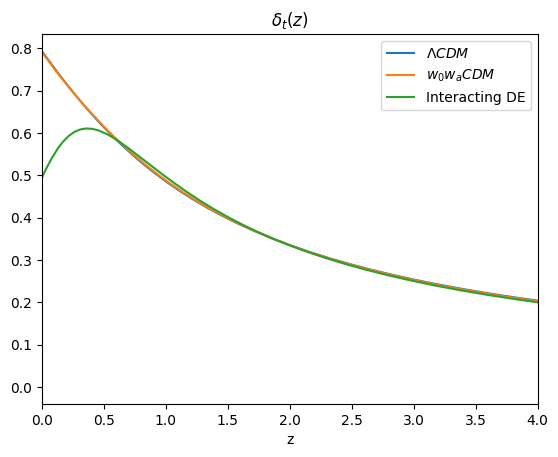

In [59]:
plt.plot(1/ptLCDM[0]['a']-1,delta_t_lcdm/delta_t_lcdm[-20]*ptLCDM[0]['a'][-20],label=legend_labels[0])
plt.plot(1/ptFLD[0]['a']-1,delta_t_fld/delta_t_fld[-20]*ptFLD[0]['a'][-20],label=legend_labels[1])
plt.plot(1/ptINT[0]['a']-1,delta_t_int/delta_t_int[-20]*ptINT[0]['a'][-20],label=legend_labels[2])
# plt.plot(1/ptLCDM[0]['a']-1,ptLCDM[0]['a'],label='a')
plt.legend()
plt.xlim(0,4)
plt.title(r'$\delta_t(z)$')
plt.xlabel('z')
plt.show()

# delta = a normalizado durante a matter domination

## $f(z)$

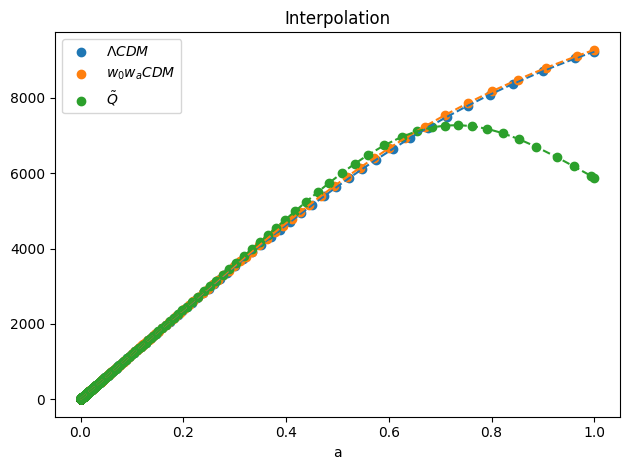

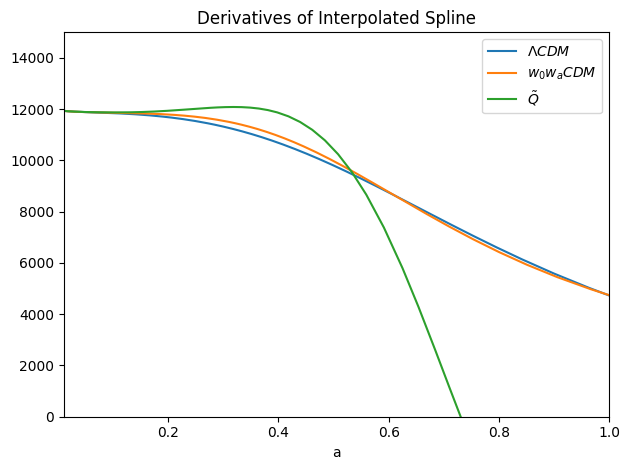

In [60]:
# Create an interpolated univariate spline (degree k=3 by default)
ius_lcdm = InterpolatedUnivariateSpline(ptLCDM[0]['a'], delta_t_lcdm)
ius_fld = InterpolatedUnivariateSpline(ptFLD[0]['a'], delta_t_fld)
ius_int = InterpolatedUnivariateSpline(ptINT[0]['a'], delta_t_int)

delta_t_lcdm_interpolated=ius_lcdm(ptLCDM[0]['a'])
delta_t_lcdm_linha=ius_lcdm.derivative(1)(ptLCDM[0]['a'])
delta_t_fld_interpolated=ius_fld(ptFLD[0]['a'])
delta_t_fld_linha=ius_fld.derivative(1)(ptFLD[0]['a'])
delta_t_int_interpolated=ius_int(ptINT[0]['a'])
delta_t_int_linha=ius_int.derivative(1)(ptINT[0]['a'])

# Original data and interpolation
plt.scatter(ptLCDM[0]['a'], delta_t_lcdm, label=r'$\Lambda CDM$')
plt.plot(ptLCDM[0]['a'], delta_t_lcdm_interpolated, linestyle="--")
plt.scatter(ptFLD[0]['a'], delta_t_fld, label=r'$w_0w_aCDM$')
plt.plot(ptFLD[0]['a'], delta_t_fld_interpolated, linestyle="--")
plt.scatter(ptINT[0]['a'], delta_t_int, label=r'$\tilde{Q}$')
plt.plot(ptINT[0]['a'], delta_t_int_interpolated, linestyle="--")
plt.legend()
plt.xlabel('a')
plt.title("Interpolation")
plt.tight_layout()
plt.show()

# Derivatives
plt.plot(ptLCDM[0]['a'],delta_t_lcdm_linha,label=r'$\Lambda CDM$')
plt.plot(ptFLD[0]['a'],delta_t_fld_linha,label=r'$w_0w_aCDM$')
plt.plot(ptINT[0]['a'],delta_t_int_linha,label=r'$\tilde{Q}$')
plt.legend()
plt.title("Derivatives of Interpolated Spline")
plt.ylim(0,1.5e4)
plt.xlim(0.01,1)
plt.xlabel('a')
plt.tight_layout()
plt.show()

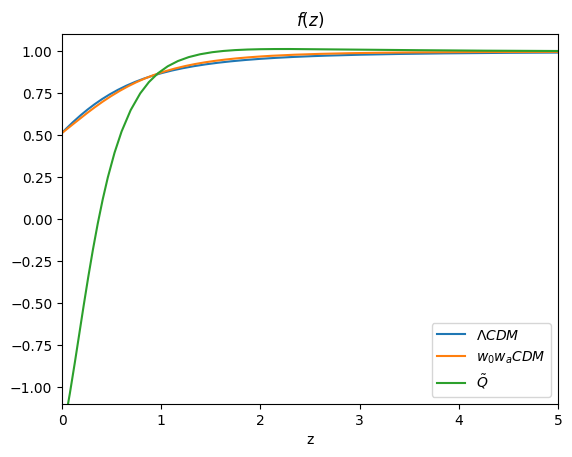

In [61]:
f_lcdm=delta_t_lcdm_linha/delta_t_lcdm*ptLCDM[0]['a']
f_fld=delta_t_fld_linha/delta_t_fld*ptFLD[0]['a']
f_int=delta_t_int_linha/delta_t_int*ptINT[0]['a']

def f_z(z,w0,wa):
    return (omega_b_int(z,w0,wa)+omega_c_int(z,w0,wa))**(.55)

plt.plot(1/ptLCDM[0]['a']-1,f_lcdm,label=r'$\Lambda CDM$')
plt.plot(1/ptFLD[0]['a']-1,f_fld,label=r'$w_0w_aCDM$')
plt.plot(1/ptINT[0]['a']-1,f_int,label=r'$\tilde{Q}$')
plt.title(r'$f(z)$')
plt.legend()
plt.xlim(0,5)
plt.ylim(-1.1,1.1)
plt.xlabel('z')
plt.savefig('f1.pdf')
plt.show()

## $D(z)$

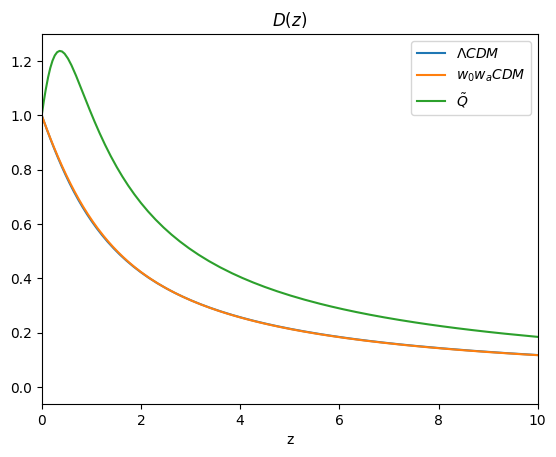

In [62]:
d_lcdm=delta_t_lcdm/delta_t_lcdm[-1]
d_fld=delta_t_fld/delta_t_fld[-1]
d_int=delta_t_int/delta_t_int[-1]

plt.plot(1/ptLCDM[0]['a']-1,d_lcdm,label=r'$\Lambda CDM$')
plt.plot(1/ptFLD[0]['a']-1,d_fld,label=r'$w_0w_aCDM$')
plt.plot(1/ptINT[0]['a']-1,d_int,label=r'$\tilde{Q}$')
plt.xlim(0,10)
plt.title(r'$D(z)$')
plt.legend()
plt.xlabel('z')
plt.show()

## $\sigma_8(z)$

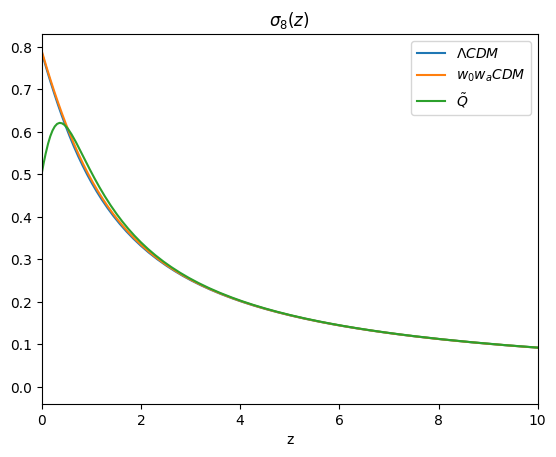

In [63]:
sigma8_lcdm=LCDM.sigma8()*d_lcdm
sigma8_fld=FLD.sigma8()*d_fld
sigma8_int=INT.sigma8()*d_int

plt.plot(1/ptLCDM[0]['a']-1,sigma8_lcdm,label=r'$\Lambda CDM$')
plt.plot(1/ptFLD[0]['a']-1,sigma8_fld,label=r'$w_0w_aCDM$')
plt.plot(1/ptINT[0]['a']-1,sigma8_int,label=r'$\tilde{Q}$')
plt.xlim(0,10)
plt.title(r'$\sigma_8(z)$')
plt.legend()
plt.xlabel('z')
plt.show()

## $f(z)\sigma_8(z)$

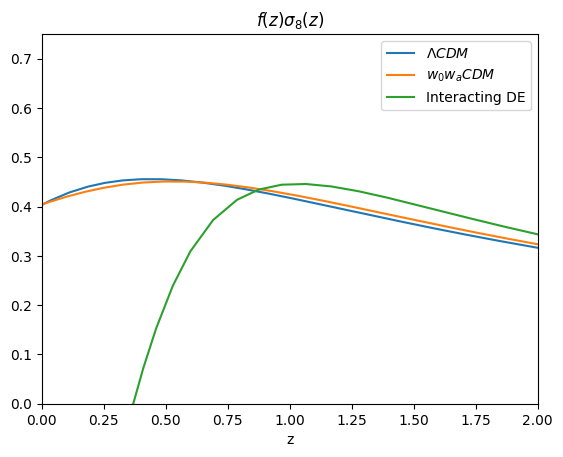

In [64]:
z_lcdm=1/ptLCDM[0]['a']-1
z_fld=1/ptFLD[0]['a']-1
z_int=1/ptINT[0]['a']-1

fsigma8_lcdm=f_lcdm*sigma8_lcdm
fsigma8_fld=f_fld*sigma8_fld
fsigma8_int=f_int*sigma8_int

plt.plot(1/ptLCDM[0]['a']-1,fsigma8_lcdm,label=legend_labels[0])
plt.plot(1/ptFLD[0]['a']-1,fsigma8_fld,label=legend_labels[1])
plt.plot(1/ptINT[0]['a']-1,fsigma8_int,label=legend_labels[2])
plt.legend()
plt.xlim(0,2)
plt.ylim(0,0.75)
plt.title(r'$f(z)\sigma_8(z)$')
plt.xlabel('z')
plt.show()